# MNIST Classifier  
  
Using Pytorch and CNNs to build a classifier for the MNIST dataset

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torchvision.transforms import ToTensor
import numpy as np

## Data Read

In [3]:
custom_train_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to a PyTorch tensor
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.RandomRotation(degrees=30),  # Apply random rotation (range: -30 to +30 degrees)
])
custom_val_transform = transforms.Compose([
    transforms.ToTensor() # Converts image to a PyTorch tensor
])

In [4]:
## Read in MNIST dataset

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=custom_train_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=custom_val_transform
)


0
label =  [5]


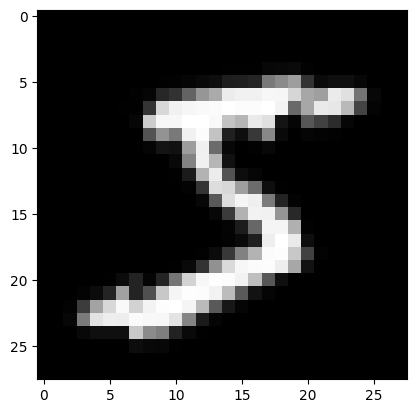

In [5]:
import matplotlib.pyplot as plt 

# Playing around a bit with DataLoaders so we can understand what is going on

train_dataloader = DataLoader(training_data, batch_size=1, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=1, num_workers=1)

for batch, (img, label) in enumerate(train_dataloader):
    print(batch)
    print("label = ", label.numpy())
    plt.figure()
    plt.imshow(img.squeeze(), cmap='grey')
    plt.show()
    break

## Define the Model

In [6]:
import torch.nn as nn 
import torch.nn.functional as F

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Griff_CNN(nn.Module):

    def __init__(self):
        super(Griff_CNN, self).__init__()

        # First convolutional layer + batch normalization
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # should be 16x28x28 after
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm for 16 channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # should be 16x14x14 after
        
        # Second convolutional layer + batch normalization
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=1) # should be 24x14x14 after
        self.bn2 = nn.BatchNorm2d(24)  # BatchNorm for 24 channels
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # should be 24x7x7 after
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=24*7*7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x): 
        # First convolution block
        x = self.conv1(x)
        x = self.bn1(x)  # Batch Normalization after convolution
        x = F.relu(x)  # Apply ReLU after BatchNorm
        x = self.pool1(x)  # Max pooling
        
        # Second convolution block
        x = self.conv2(x)
        x = self.bn2(x)  # Batch Normalization after convolution
        x = F.relu(x)  # Apply ReLU after BatchNorm
        x = self.pool2(x)  # Max pooling
        
        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, start_dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Final output
        
        return x


In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [9]:
model = Griff_CNN().to(device)

In [10]:
# test that results are sensible

input_tensor = torch.randn(1, 1, 28, 28).to(device)
output = model(input_tensor)
print(output)

tensor([[-0.0669,  0.0046, -0.1678,  0.0181,  0.2806, -0.0175, -0.0244, -0.1533,
          0.0095, -0.0024]], device='mps:0', grad_fn=<LinearBackward0>)


## Training

In [11]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
# Define key hyperparameters

batchsize = 64 # mini-batch size 
nworkers = 4
lr = 1.0e-3 # learning rate
epochs = 20 # number of training epochs 
# ADAM optimiser parameter
beta1 = 0.9 
beta2 = 0.999 
eps = 1.0e-8
lambd = 0.

In [13]:
# Define optimiser
optimiser = torch.optim.Adam(model.parameters(), 
                             lr=lr, 
                             betas=(beta1, beta2), 
                             eps=eps, 
                             weight_decay=lambd)

In [14]:
train_dataloader = DataLoader(training_data, batch_size=batchsize, num_workers=nworkers)
test_dataloader = DataLoader(test_data, batch_size=batchsize, num_workers=nworkers)

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward prediction
        pred = model(X) 
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batchsize + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    history['test_loss'].append(loss)

In [16]:
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0., 0. 

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) 
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches 
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    history['val_loss'].append(test_loss)
    history['accuracy'].append(correct)

In [17]:
history = {'epoch' : [], 
           'test_loss' : [],
           'val_loss': [],
           'accuracy' : []
}

In [18]:
for t in range(epochs):
    history['epoch'].append(t+1)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, history)
    test_loop(test_dataloader, model, loss_fn, history)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293190  [   64/60000]
loss: 0.420322  [ 6464/60000]
loss: 0.142109  [12864/60000]
loss: 0.163325  [19264/60000]
loss: 0.151048  [25664/60000]
loss: 0.336974  [32064/60000]
loss: 0.128814  [38464/60000]
loss: 0.217298  [44864/60000]
loss: 0.226916  [51264/60000]
loss: 0.139199  [57664/60000]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.091232 

Epoch 2
-------------------------------
loss: 0.084043  [   64/60000]
loss: 0.116076  [ 6464/60000]
loss: 0.020170  [12864/60000]
loss: 0.075703  [19264/60000]
loss: 0.078890  [25664/60000]
loss: 0.156442  [32064/60000]
loss: 0.083272  [38464/60000]
loss: 0.174621  [44864/60000]
loss: 0.387920  [51264/60000]
loss: 0.112356  [57664/60000]
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.055008 

Epoch 3
-------------------------------
loss: 0.036286  [   64/60000]
loss: 0.128137  [ 6464/60000]
loss: 0.130139  [12864/60000]
loss: 0.072187  [19264/60000]
loss: 0.014720  [25664/60000]
loss: 0.085623  [32064/600

In [19]:
epochs = [item for item in history['epoch']]
test_losses = [item.item() for item in history['test_loss']]
val_losses = [item for item in history['val_loss']]

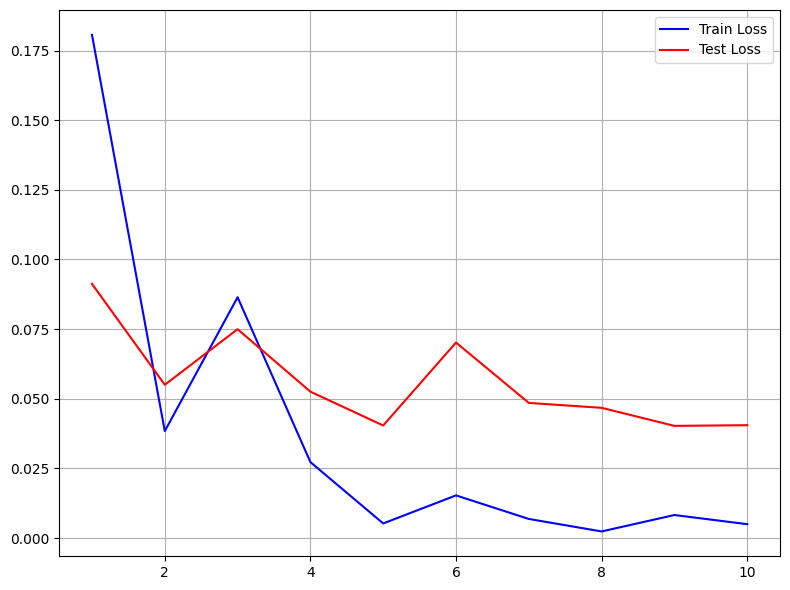

In [29]:
plt.figure(figsize = (8, 6))
plt.plot(epochs, test_losses, color = 'blue', label = "Train Loss")
plt.plot(epochs, val_losses, color = 'red', label = "Test Loss")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

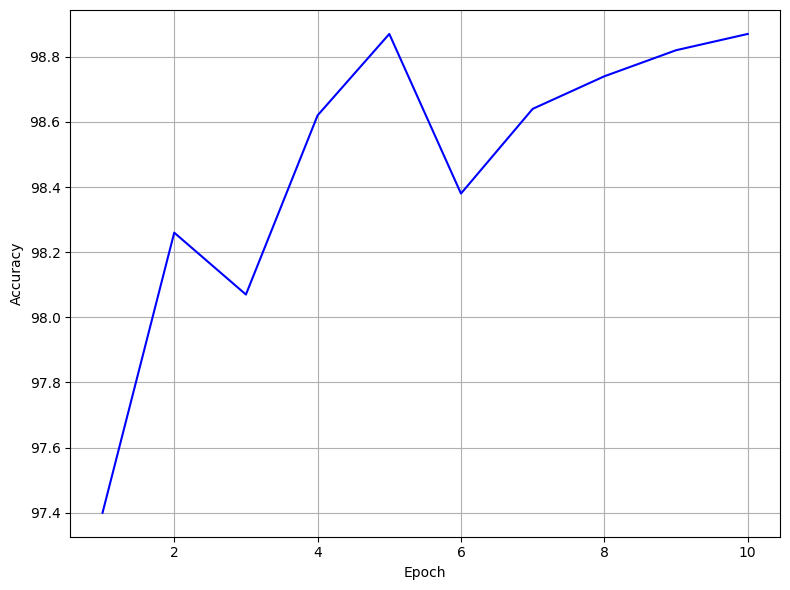

In [30]:
plt.figure(figsize = (8, 6))
plt.plot(epochs, 100*np.array(history['accuracy']), color = 'blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()